# Algorithmic Trading Pipeline
# Complete Workflow: Data → Model → Strategy → Backtest → Analysis

This notebook demonstrates the full pipeline for:
1. Loading/creating data catalog
2. Model hyperparameter optimization
3. Strategy hyperparameter optimization
4. Final backtest execution
5. Performance analysis and visualization

---
## Stage 0: Setup & Configuration
Load dependencies and configuration

In [1]:
# Use to debugging
%load_ext autoreload
%autoreload 2

# Core imports
from pathlib import Path
import yaml
import logging
import pandas as pd
import mlflow
from mlflow import MlflowClient
import tqdm as notebook_tqdm


# Nautilus Trader
from nautilus_trader.model.objects import Currency
from nautilus_trader.core.nautilus_pyo3 import CurrencyType
from nautilus_trader.persistence.catalog import ParquetDataCatalog
from nautilus_trader.model.data import TradeTick

# Project modules
from algos.engine.databento_loader import DatabentoTickLoader
from algos.engine.hparam_tuner import OptunaHparamsTuner
from algos.engine.performance_plots import (
    get_frequency_params, align_series,
    plot_balance_breakdown, plot_cumulative_returns,
    plot_rolling_sharpe, plot_underwater,
    plot_active_returns, plot_portfolio_allocation
)

# Setup logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

In [2]:
# Load configuration
cfg_path = Path("configs/config.yaml")
cfg = yaml.safe_load(cfg_path.read_text(encoding="utf-8"))

# Setup currency
currency_code = cfg["STRATEGY"]["PARAMS"]["currency"]
if currency_code == "USD":
    cfg["STRATEGY"]["PARAMS"]["currency"] = Currency(
        code='USD', precision=3, iso4217=840,
        name='United States dollar', currency_type=CurrencyType.FIAT
    )
elif currency_code == "EUR":
    cfg["STRATEGY"]["PARAMS"]["currency"] = Currency(
        code='EUR', precision=3, iso4217=978,
        name='Euro', currency_type=CurrencyType.FIAT
    )

# Setup directories
logs_dir = Path("logs/")
logs_dir.mkdir(parents=True, exist_ok=True)

print("Configuration loaded successfully")
print(f"Model: {cfg['MODEL']['PARAMS']['model_name']}")
print(f"Strategy: {cfg['STRATEGY']['PARAMS']['strategy_name']}")
print(f"Backtest period: {cfg['STRATEGY']['PARAMS']['backtest_start']} to {cfg['STRATEGY']['PARAMS']['backtest_end']}")

Configuration loaded successfully
Model: UMIModel
Strategy: TopKStrategy
Backtest period: 2024-06-01 to 2024-07-01


---
## Stage 1: Data Catalog and HyperParameter Tuner setup
Load or create Nautilus Trader data catalog from Databento tick data

In [ ]:
# Configuration
FORCE_RELOAD_CATALOG = False  # Set to True to rebuild catalog
CATALOG_PATH = None  # Set custom path or None for default

# Initialize loader
logger.info("Initializing Databento loader...")
loader = DatabentoTickLoader(
    cfg=cfg["STRATEGY"]["PARAMS"],
    venue_name=cfg["STRATEGY"]["PARAMS"]["venue_name"]
)

# Determine catalog path
catalog_path = Path(CATALOG_PATH) if CATALOG_PATH else loader.catalog_path

# Load or create catalog
if not FORCE_RELOAD_CATALOG and loader.catalog_exists(catalog_path):
    logger.info(f"📂 Reusing existing catalog at: {catalog_path}")
    catalog = ParquetDataCatalog(path=str(catalog_path))
else:
    logger.info(f"🔄 Loading Databento ticks to catalog at: {catalog_path}")
    if FORCE_RELOAD_CATALOG:
        logger.info("Force reload enabled - rebuilding catalog")
    
    # Load with progress bar and memory management
    catalog = loader.load_to_catalog(
        catalog_path=catalog_path,
    )

# Add catalog path to config
cfg["STRATEGY"]["PARAMS"]["catalog_path"] = str(catalog_path)

# Verify catalog
instruments = set(inst.id.value for inst in catalog.instruments())
print(f"\n✅ Catalog ready: {catalog.list_data_types()} data loaded")
print(f"Universe: {[str(symbol) for symbol in instruments]}")


2025-10-26 16:50:16,062 - __main__ - INFO - Initializing Databento loader...
2025-10-26 16:50:16,068 - __main__ - INFO - 📂 Reusing existing catalog at: C:\Users\gianc\Desktop\PYTHON\sapiens\data\nautilus_catalog



✅ Catalog ready: ['trade_tick'] data loaded
Universe: ['AAPL', 'GOOGL', 'MSFT', 'SGOV', 'SPY']


In [ ]:
# Initialize hyperparameter tuner
tuner = OptunaHparamsTuner(
    cfg=cfg,
    catalog=catalog,
    run_dir=logs_dir,
    seed=2025
)


print("Hyperparameter tuner initialized")
print(f"Model trials: {cfg['MODEL']['PARAMS']['n_trials']}")
print(f"Strategy trials: {cfg['STRATEGY']['PARAMS']['n_trials']}")

Hyperparameter tuner initialized
Model trials: 2
Strategy trials: 2


---
## Stage 2: Model Hyperparameter Optimization
Optimize model hyperparameters using Optuna

In [ ]:
# Run model hyperparameter optimization
logger.info("\n" + "="*70)
logger.info("🔬 STAGE 2: MODEL HYPERPARAMETER OPTIMIZATION")
logger.info("="*70 + "\n")

model_results = tuner.optimize_model()

print("\n✅ Model optimization complete!")
print(f"Best model path: {model_results['model_path']}")
print(f"MLflow run ID: {model_results['mlflow_run_id']}")

2025-10-26 16:50:16,472 - __main__ - INFO - 
2025-10-26 16:50:16,473 - __main__ - INFO - 🔬 STAGE 2: MODEL HYPERPARAMETER OPTIMIZATION
2025-10-26 16:50:16,473 - __main__ - INFO - ======================================================================

[I 2025-10-26 16:50:16,771] Using an existing study with name 'UMIModel' instead of creating a new one.
2025-10-26 16:50:16,791 - algos.engine.hparam_tuner - INFO - Running 2 model trials...
2025-10-26 16:50:18,075 - algos.engine.hparam_tuner - INFO - AAPL.SIM: 534,067 total ticks → 513,372 in market hours (20,695 pre/after-hours excluded, 3.9%)
2025-10-26 16:50:18,830 - algos.engine.hparam_tuner - INFO - GOOGL.SIM: 303,099 total ticks → 293,277 in market hours (9,822 pre/after-hours excluded, 3.2%)
2025-10-26 16:50:19,510 - algos.engine.hparam_tuner - INFO - MSFT.SIM: 437,805 total ticks → 424,029 in market hours (13,776 pre/after-hours excluded, 3.1%)
2025-10-26 16:50:19,575 - algos.engine.hparam_tuner - INFO - SGOV.SIM: 2,272 total ticks


✅ Model optimization complete!
Best model path: logs\Models\UMIModel\trial_2\init.pt
MLflow run ID: 9a20d888f0974322a8709daff255536a


---
## Stage 3: Strategy Hyperparameter Optimization
Optimize strategy hyperparameters using best model from Stage 2

2025-10-26 16:51:13,289 - __main__ - INFO - 
2025-10-26 16:51:13,290 - __main__ - INFO - 📊 STAGE 3: STRATEGY HYPERPARAMETER OPTIMIZATION
2025-10-26 16:51:13,290 - __main__ - INFO - ======================================================================



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[I 2025-10-26 16:51:13,815] Using an existing study with name 'TopKStrategy_UMIModel' instead of creating a new one.
2025-10-26 16:51:13,841 - root - INFO - No previous old best trial of strategy hpo
2025-10-26 16:51:13,842 - algos.engine.hparam_tuner - INFO - Running 2 strategy trials...


2025-10-26 16:51:15,204 - algos.TopKStrategy - INFO - OrderManager initialized
2025-10-26 16:51:15,227 - algos.TopKStrategy - INFO - Selected 0 from 0 candidates (including benchmark and risk-free) 
2025-10-26 16:51:15,227 - algos.TopKStrategy - INFO - NAV Calculation: Cash=20000.00, Positions=0.00, Total=19950.00
2025-10-26 16:51:15,228 - algos.TopKStrategy - INFO - Model UMIModel found in logs\Models\UMIModel\trial_2 . Loading in process...
c:\Users\gianc\Desktop\PYTHON\sapiens\.venv\Lib\site-packages\torch\nn\modules\transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
2025-10-26 16:51:15,249 - algos.TopKStrategy - INFO - Model UMIModel stored in logs\Models\UMIModel\trial_2 loaded successfully
c:\Users\gianc\Desktop\PYTHON\sapiens\algos\TopKStrategy.py:254: FutureWarning: Minute.delta is deprecated and will be removed in a future version. Use pd.Timedelta(obj) instead
  i

TypeError: float() argument must be a string or a real number, not 'DataFrame'

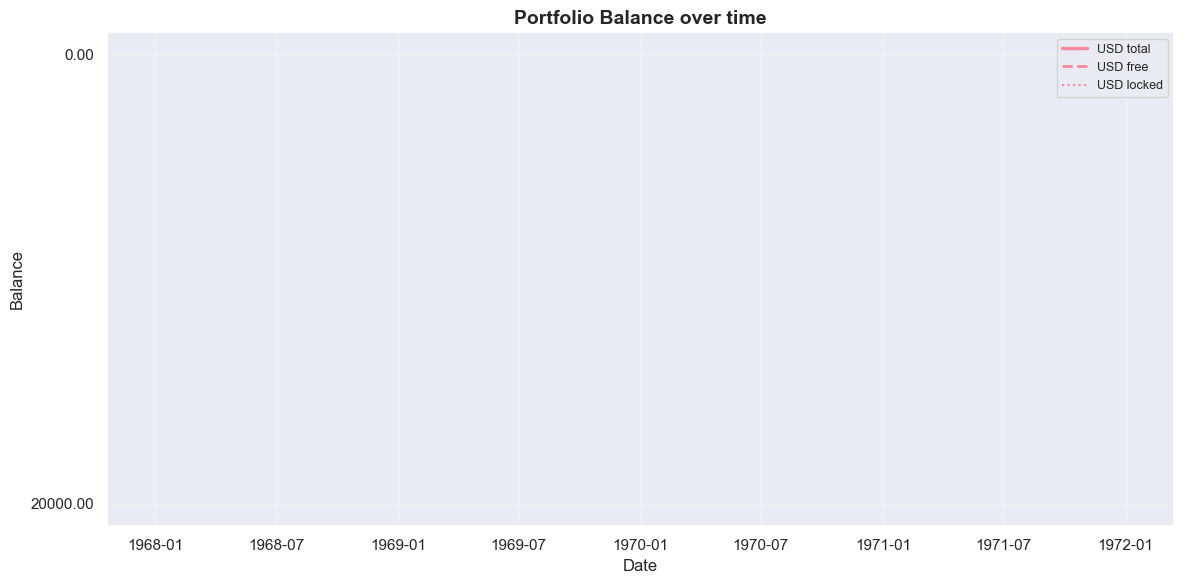

In [6]:
# Use to debugging
%load_ext autoreload
%autoreload 2

# Run strategy hyperparameter optimization
logger.info("\n" + "="*70)
logger.info("📊 STAGE 3: STRATEGY HYPERPARAMETER OPTIMIZATION")
logger.info("="*70 + "\n")

model_name = cfg['MODEL']['PARAMS']['model_name']
strategy_results = tuner.optimize_strategy(model_name=model_name)

print("\n✅ Strategy optimization complete!")
print(f"Best hyperparameters: {strategy_results['hparams']}")
print(f"\nBest metrics:")
for metric, value in strategy_results['metrics'].items():
    print(f"  {metric}: {value:.4f}")
print(f"\nMLflow run ID: {strategy_results['mlflow_run_id']}")

---
## Stage 4: Final Backtest
Run final backtest on full period with optimized hyperparameters

In [ ]:
# Get optimization context
run = mlflow.get_run(strategy_results["mlflow_run_id"])
optimization_id = run.data.tags.get("optimization_id", "")

# Define backtest period
backtest_start = cfg["STRATEGY"]["PARAMS"]["backtest_start"]
backtest_end = cfg["STRATEGY"]["PARAMS"]["backtest_end"]

print(f"Running final backtest: {backtest_start} to {backtest_end}")

In [ ]:
# Execute final backtest
logger.info("\n" + "="*70)
logger.info("🚀 STAGE 4: FINAL BACKTEST")
logger.info("="*70 + "\n")

final_metrics, final_time_series = tuner.run_final_backtest(
    backtest_start=backtest_start,
    backtest_end=backtest_end,
    strategy_hpo_run_id=strategy_results["mlflow_run_id"],
    optimization_id=optimization_id
)

print("\n✅ Final backtest complete!")
print("\nFinal Performance Metrics:")
print("="*50)
for metric, value in sorted(final_metrics.items()):
    print(f"{metric:.<40} {value:>10.4f}")

---
## Stage 5: Performance Analysis
Detailed analysis and visualization of backtest results

In [ ]:
# Load results from MLflow
client = MlflowClient(tracking_uri="file:logs/mlflow")

# Get the most recent backtest run
exp = client.get_experiment_by_name("Backtests")
if not exp:
    exp_id = client.create_experiment("Backtests")
else:
    exp_id = exp.experiment_id
runs = client.search_runs(
    experiment_ids=[exp_id],
    order_by=["start_time DESC"],
    max_results=1
)
backtest_run = runs[0]
backtest_run_id = backtest_run.info.run_id

print(f"Loading backtest run: {backtest_run_id}")

In [ ]:
# Load account and positions data
acc_path = client.download_artifacts(run_id=backtest_run_id, path="account_report.csv")
pos_path = client.download_artifacts(run_id=backtest_run_id, path="positions_report.csv")

account_df = pd.read_csv(acc_path, index_col=0, parse_dates=True)
positions_df = pd.read_csv(pos_path, index_col=0, parse_dates=True)

print(f"Account snapshots: {len(account_df)}")
print(f"Position records: {len(positions_df)}")

In [ ]:
# Calculate returns
freq = cfg['STRATEGY']['PARAMS']['freq']
freq_params = get_frequency_params(freq)

# Extract portfolio values
currency_code = cfg['STRATEGY']['PARAMS']['currency'].code
portfolio_values = account_df[account_df['currency'] == currency_code]['total']
portfolio_values = portfolio_values.resample(freq_params['resample_freq']).last().ffill()
strategy_ret = portfolio_values.pct_change().fillna(0)

# Load benchmark and risk-free data
data_dict = loader.get_ohlcv_data(frequency=freq)
benchmark_ticker = cfg['STRATEGY']['PARAMS']['benchmark_ticker']
risk_free_ticker = cfg['STRATEGY']['PARAMS']['risk_free_ticker']
benchmark_ret = data_dict[benchmark_ticker]['close'].pct_change()
rf_ret = data_dict[risk_free_ticker]['close'].pct_change()

# Align series
strategy_ret, benchmark_ret, rf_ret = align_series(
    strategy_ret, benchmark_ret, rf_ret, freq_params['resample_freq']
)

print(f"Returns calculated for {len(strategy_ret)} periods")

### 5.1: Balance Over Time

In [ ]:
fig = plot_balance_breakdown(
    account_df=account_df,
    resample_freq=freq_params['resample_freq']
)

### 5.2: Cumulative Returns

In [ ]:
fig = plot_cumulative_returns(
    strategy_ret=strategy_ret,
    benchmark_ret=benchmark_ret
)

### 5.3: Rolling Sharpe Ratio

In [ ]:
window = max(10, int(freq_params['periods_per_year'] / 12))
fig = plot_rolling_sharpe(
    strategy_ret=strategy_ret,
    benchmark_ret=benchmark_ret,
    rf_ret=rf_ret,
    window=window,
    annualization_factor=freq_params['annualization_factor']
)

### 5.4: Drawdown Analysis

In [ ]:
fig = plot_underwater(strategy_ret=strategy_ret)

### 5.5: Active Returns

In [ ]:
fig = plot_active_returns(
    strategy_ret=strategy_ret,
    benchmark_ret=benchmark_ret,
    freq=freq
)

### 5.6: Portfolio Allocation

In [ ]:
fig = plot_portfolio_allocation(
    positions_df=positions_df,
    resample_freq=freq_params['resample_freq']
)

### 5.7: Summary Statistics

In [ ]:
# Calculate summary statistics
total_return = (1 + strategy_ret).prod() - 1
annualized_return = (1 + total_return) ** (freq_params['periods_per_year'] / len(strategy_ret)) - 1
annualized_vol = strategy_ret.std() * freq_params['annualization_factor']
sharpe_ratio = (strategy_ret.mean() - rf_ret.mean()) / strategy_ret.std() * freq_params['annualization_factor']

# Drawdown
cumulative = (1 + strategy_ret).cumprod()
running_max = cumulative.expanding().max()
drawdown = (cumulative - running_max) / running_max
max_drawdown = drawdown.min()

# Win rate
winning_periods = (strategy_ret > 0).sum()
win_rate = winning_periods / len(strategy_ret)

# Create summary DataFrame
summary = pd.DataFrame({
    'Metric': [
        'Total Return (%)',
        'Annualized Return (%)',
        'Annualized Volatility (%)',
        'Sharpe Ratio',
        'Max Drawdown (%)',
        'Win Rate (%)',
        'Number of Periods'
    ],
    'Value': [
        f"{total_return * 100:.2f}",
        f"{annualized_return * 100:.2f}",
        f"{annualized_vol * 100:.2f}",
        f"{sharpe_ratio:.2f}",
        f"{max_drawdown * 100:.2f}",
        f"{win_rate * 100:.2f}",
        len(strategy_ret)
    ]
})

print("\n" + "="*60)
print("PERFORMANCE SUMMARY")
print("="*60)
print(summary.to_string(index=False))

---
## Comparison Matrix: All Models × Strategies

In [ ]:
# Generate HPO results matrix
hpo_matrix = tuner.get_strategy_hpo_matrix(metric="total_pnl_pct")
print("\nStrategy HPO Results Matrix (total_pnl_pct):")
print(hpo_matrix)

# Generate final backtest results matrix
backtest_matrix = tuner.get_final_backtest_matrix(metric="sharpe_ratio")
print("\nFinal Backtest Results Matrix (sharpe_ratio):")
print(backtest_matrix)

---
## Pipeline Complete ✅

**Next Steps:**
- Review MLflow UI: `mlflow ui --backend-store-uri logs/mlflow`
- Explore experiment tracking and compare runs
- Adjust hyperparameters in `configs/config.yaml` and rerun
- Export results for production deployment